In [107]:
import numpy as np
# This script generates the input files calculating linear abs for NISE
# It will also run the NISE calculations provided that the correct path to
# NISE program is ndicated.

# Input:
# - Site energies (text)
# - Protein structure
# Output:
# - energy trajectories
# - dipole trajectories
# - NISE input files (translation, Absorption, 2DES, ...)

def writeinput(niseDict,fname):
    with open(fname,'w') as f:
        for key,value in niseDict.items():
            f.write('%s %s\n' % (key, value))
            
#  Files
f_pdb = '1rwt.pdb' # Structure pdb
f_site = 'Site.txt' # Site energies
f_ham = 'Energy' # Hamiltonian input for NISE
f_dp = 'Dipole' # Dipole input for NISE
f_pos = 'Position' # Position input for NISE
f_i1D = 'input1D' # NISE absorption calculation parameters
f_iTra = 'inpTra' # NISE translate parameters
f_i2D = 'input2D' # NISE 2D calculation parameters
f_iCG2D = 'inputCG2D' # NISE coarse grained 2D calculation
f_iDif = 'inputDif' # NISE Diffusion
f_iPop = 'inputPop' # NISE population transfer
f_iAnalyse = 'inputAnalyse' # NISE Analyze
f_iLum = 'inputLum' # NISE Luminescence
f_iCD = 'inputCD' # NISE circular dichroism
f_iLD = 'inputLD' # NISE linear dichroism
f_iDOS = 'inputDOS' # NISE density of states

# Parameter
E0 = np.genfromtxt('Site.txt') # Site energies [cm-1]
E0 = E0.astype('int16')
sigma = np.array([150, 60]) # Disorders (static & dynamic) [cm-1]
tauc = np.array([100, 1000000]) # Correlation time [fs]
dt = 1 # Time step [fs]
N = E0.size # Number of chromophores (singles)
Nstep = 10001 # Number of time steps
taudeph = 100 # Dephasing time [fs]
t1 = np.array(range(0,Nstep,dt)) # Time array [fs]
Tw = 0 # Waiting time for 2DES [fs]
T = 300 # Temperature [K]

### NISE input parameters
# For translation between bin and txt
niseTra = {
    'InputEnergy': f_ham + '.bin',
    'InputDipole': f_dp + '.bin',
    'OutputEnergy': f_ham + '.txt',
    'OutputDipole': f_dp + '.txt',
    'Singles': N,
    'Doubles': 0,
    'Skip': 'Doubles',
    'Length': Nstep,
    'InputFormat': 'GROBIN',
    'OutputFormat': 'GROASC'
}

# For 1D (absorption) calculation
nise1D = {
    'Propagation': 'Coupling',
    'Couplingcut': 0,
    'Threshold': 0.001,
    'Hamiltonianfile': f_ham + '.bin',
    'Dipolefile': f_dp + '.bin',
    'Length': Nstep,
    'Samplerate': 20,
    'Lifetime': taudeph,
    'Timestep': dt,
    'Trotter': 1,
    'Anharmonicity': 100,
    'Format': 'Dislin',
    'MinFrequencies': ' '.join(map(str, [14000, 14000, 14000])),
    'MaxFrequencies': ' '.join(map(str, [16500, 16500, 16500])),
    'Technique': 'Absorption',
    'FFT': 2048,
    'RunTimes': [round(1.5*taudeph/dt), 0, round(1.5*taudeph/dt)],
    'Singles': N
}

### Generate energy trajectories
# Generating the trajectories of E0 based on overdamped brownian oscillator model
# The amplitude is sigma, corrleation time is tauc
dE = np.zeros((N,Nstep))
E = np.copy(dE)
dE[:,0] = np.sum(sigma*np.random.randn(N,len(sigma)),axis=1)
E[:,0] = E0 + dE[:,0]
for nt in range(1,Nstep):
    dE[:,nt] = dE[:,nt-1]*np.prod(np.exp(-1/tauc*(t1[nt]-t1[nt-1]))) + np.sum(sigma*np.random.randn(N,len(sigma))*np.sqrt(1-np.exp(-2/tauc*(t1[nt]-t1[nt-1]))),axis=1)
    E[:,nt] = E0 + dE[:,nt]

### Pick desired molecules from pdb file
from Bio.PDB import *
p = PDBParser()
s = p.get_structure("1rwt", "1rwt.pdb")
# Choose chains, residues and atom types                    
pick_chain = "C"
pick_residue = ["CHL","CLA"]
pick_atom = ["MG","NA","NB","NC","ND"]
# get coordinates for MG, NA, NB, NC, ND
mg = np.empty
na = np.empty
nb = np.empty
nc = np.empty
nd = np.empty
res_list = Entity.Entity(pick_chain)
for chains in s:
    for chain in chains:
        if chain.id in pick_chain:
            for residue in chain:
                if residue.resname in pick_residue: 
                    residue.id = residue.id + tuple(chain.id) 
                    Entity.Entity.add(res_list,residue)

### Calculate transition dipoles
DS = {"CHL": 15,
      "CLA": 21,
      "PHO": 13} # Dipole strengths [debye^2]
n = 1.4 # Refractive index
C = 1/n**2 # Influence of medium
N = len(res_list) # Number of pigments
D = np.zeros(N) # Dipole strength [debye^2]
center = np.zeros((N,3)) # Center of pigments [Ang]
Dvec = np.zeros((N,3)) # Dipole normalized coordinate
R = np.zeros((N,N)) # Distances between pigments [nm]
V = np.zeros((N,N)) # Coupling energies [cm-1]

# Get pigment position and dipole vector
i = 0
for residue in res_list:
      for atom in residue:
            if atom.id=="MG":
                  atomMG = atom.coord
            if atom.id=="NB":
                  atomNB = atom.coord
            if atom.id=="ND":
                  atomND = atom.coord
      D[i] = DS.get(residue.resname)
      center[i,:] = atomMG
      mu = atomND - atomNB
      Dvec[i,:] = mu/np.linalg.norm(mu)            
      i = i + 1

# Calculate coupling
for i in range(1,N):
      for j in range(i):
            r = center[i,:] - center[j,:]
            r = r/10 # Change to nm
            R[i,j] = np.linalg.norm(r)
            mu_i = Dvec[i,:]*np.sqrt(D[i])
            mu_j = Dvec[j,:]*np.sqrt(D[j])
            V[i,j] = 5.04*C*\
                     (np.dot(mu_i,mu_j)/R[i,j]**3 - \
                      3*np.dot(r,mu_i)*np.dot(r,mu_j)/R[i,j]**5)
V = V + np.transpose(V)
R = R + np.transpose(R)

### Write to files
# Generate energy and dipole files
fid_ham = open(f_ham+'.bin','w')
fid_dp = open(f_dp+'.bin','w')
for nt in range(Nstep):
    step = np.array(nt,'float32')
    # Write energy file
    H = np.triu(np.diag(E[:,nt])+V)
    H = H[np.nonzero(H)]
    H = H.astype('float32')
    step.tofile(fid_ham)
    H.tofile(fid_ham)
    # Write dipole file
    mu = np.multiply(np.transpose(Dvec),np.sqrt(D))
    mu = np.reshape(mu,np.size(mu))
    mu = mu.astype('float32')
    step.tofile(fid_dp)
    mu.tofile(fid_dp)


fid_ham.close
fid_dp.close

writeinput(niseTra,f_iTra)
writeinput(nise1D,f_i1D)




/home/long/.local/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 19361.
  warnings.warn(
/home/long/.local/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 20534.
  warnings.warn(
/home/long/.local/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 21816.
  warnings.warn(
/home/long/.local/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 22922.
  warnings.warn(
/home/long/.local/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 24160.
  warnings.warn(
/home/long/.local/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 25332.
  w

In [105]:
print(np.arange(3))

[0 1 2]


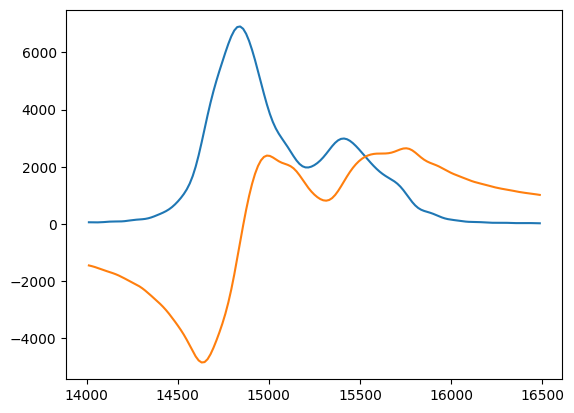

In [114]:
import matplotlib.pyplot as plt
datlin = np.genfromtxt('Absorption.dat')
fig, ax = plt.subplots()
ax.plot(datlin[:,0],datlin[:,1])
ax.plot(datlin[:,0],datlin[:,2])
